# Figure 2

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col
import pandas as pd
import scipy.stats as stats
from tqdm import tqdm
import logging
import matplotlib.cm as cm
from xhistogram.xarray import histogram


logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/x77/wf4500/ASC_project/analysis_figs/'

In [2]:
client = Client(memory_limit='1200gb',n_workers=48)


Importing data

In [ ]:
#Cross slope heat transport + ZC 
# Load CSHT field
CSHT_along_fine = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/'\
'Cross_slope_heat_transport/OM2_IAF/daily_rho/*').resample(time='1M').mean()

#importing u_along in thin bins
u_along_unbinned_fine = xr.open_mfdataset('/g/data/x77/wf4500/ASC_project/ASC_speed/daily_rho/OM2_IAF_XYgrid/*').resample(time='1M').mean()
u_along_unbinned_fine.u_along_contour.resample(time='1M').mean()

#10 degrees binned ASC data monthly
u_along_unbinned_10deg = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_10deg_bin.nc')




In [4]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHT_along_fine.lon_bin_midpoints[0], CSHT_along_fine.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHT_along_fine.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)
longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])

In [ ]:
#binning CHST into 10 degrees bins
#creating a halo
CSHT_halo = xr.concat([CSHT_along_fine.binned_cross_slope_heat_trans,CSHT_along_fine.binned_cross_slope_heat_trans.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08
CSHT_along_10deg = CSHT_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 


#now for the CSHT + zonal convergence
CSHTZC_halo = xr.concat([(CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence),\
                         (CSHT_along_fine.binned_cross_slope_heat_trans +CSHT_along_fine.zonal_convergence)\
                         .isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')*0.08

CSHTZC_along_10deg = CSHTZC_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') 

del CSHT_halo, CSHTZC_halo


CSHT_along_10deg.load()
CSHTZC_along_10deg.load()


In [6]:
#getting correction factor for the CSHT
factor = 1/((CSHT_along_fine.zonal_convergence + CSHT_along_fine.binned_cross_slope_heat_trans)\
.mean('time').sum()/ (CSHT_along_fine.unbinned_heat_transp_across_contour.mean('time').sum()))

In [7]:
#Importing masks 
CDW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/CDW_age_mask.nc').CDW_mask.load()
DSW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/DSW_age_mask.nc').DSW_mask.load()
AASW_mask = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/AASW_age_mask.nc').AASW_mask.load()

Importing $\sigma_0(z)$ for density curtains

In [8]:
iaf_cycle3 = '01deg_jra55v140_iaf_cycle3'
session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
ylength=580

In [9]:
%%time
# #this cell below mygh take a good time to run
CSHTZC_z = xr.open_dataset('/g/data/v45/wf4500/ASC_project_files/'+\
                           'Cross_slope_heat_transport/OM2_IAF/daily_z/'+\
                           'Ant_cross_slope_heat_terms_offline_1000m_1958-01.nc').isel(time=0)

#unbinned mask
unbinned_depth_mask=CSHTZC_z.unbinned_heat_transp_across_contour
unbinned_depth_mask = (unbinned_depth_mask.where(unbinned_depth_mask!=np.nan)*0+1)

#density
potrho_transect = cc.querying.getvar(iaf_cycle3,'pot_rho_0' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
potrho_transect = potrho_transect.sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

potrho_transect.load()
print('loaded densities along contour')

loaded densities along contour
CPU times: user 3min 42s, sys: 18.6 s, total: 4min
Wall time: 4min 9s


In [10]:
%%time
#dzt
dzt_transect= cc.querying.getvar(iaf_cycle3,'dzt' , session,frequency='1 monthly',chunks={}).isel(yt_ocean=slice(0,ylength))
dzt_transect = dzt_transect.sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask

#area
area_transect= cc.querying.getvar(iaf_cycle3,'area_t' , session,n=1).isel(yt_ocean=slice(0,ylength))
area_transect = area_transect.sel(xt_ocean = CSHT_along_fine.lon_along_contour.isel(time=0).drop('time'),\
yt_ocean=CSHT_along_fine.lat_along_contour.isel(time=0).drop('time'),method='nearest') * unbinned_depth_mask
area_transect = area_transect.drop('time')

#volume will be
vol_transect = area_transect * dzt_transect


#loading data
dzt_transect.load()
area_transect.load()
vol_transect.load()

print('unbinned volumes extracted along contour')

unbinned volumes extracted along contour
CPU times: user 8min 43s, sys: 33.6 s, total: 9min 16s
Wall time: 9min 17s


Lets now bin the density in 3 degrees, in a similar manner as it is done for the CSHT first step

In [11]:
#binning into 3deg
bin_width = 3
bin_spacing = 0.25
lon_west = -280
lon_east = 80

# new coordinate and midpoints of longitude bins:
full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)

n_bin_edges = len(full_lon_coord)
lon_along_contour = np.array(CSHTZC_z.lon_along_contour)
lat_along_contour = np.array(CSHTZC_z.lat_along_contour)
# sum into longitude bins:
# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
# on the isobath contour and sum continously along contour between defined indices.
# (i.e. lon_along_contour is not monotonic)
# find points on contour to define edges of longitude bins:
bin_edge_indices = np.zeros(n_bin_edges)
for lon_bin in range(n_bin_edges-1):
    # find first isobath point that has the right longitude:
    first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
    # then find all other isobath points with the same longitude as that first point:
    same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
    # we want the most southerly of these points on the same longitude line:
    bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
    
# define east/west edges:
bin_edge_indices = bin_edge_indices.astype(int)
bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
n_bins = len(bin_edge_indices_west)


lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
    # find nearest isobath point:
    lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
    lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]

# average the densities along the contour, in the z space
vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
potrho_transect = potrho_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
σ_contour_3deg = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    σ_contour_3deg0 = potrho_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    distance_along0 = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    #making sure we only have distances where there are values
    distance_along0 = ((σ_contour_3deg0 *0)+1) *distance_along0
    σ_contour_3deg[:,:,lon_bin] = (np.nansum(σ_contour_3deg0*distance_along0,axis=2)/np.nansum(distance_along0,axis=2))

#removing zeros
σ_contour_3degnp = np.where(σ_contour_3deg!=0,σ_contour_3deg,np.nan) - 1000



In [ ]:
# #transforming it into xarray
CSHTZC_zm = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*')


CSHT_z_monthly =( (CSHTZC_zm.binned_cross_slope_heat_trans)*factor ).resample(time='1M').mean().load()

σ_contour_3deg = CSHT_z_monthly.copy()
σ_contour_3deg.name = 'sigma0'
σ_contour_3deg.values = σ_contour_3degnp

Binning the volume in 3 degree bins too for future averaging

In [13]:
#getting the sum of the volume in 3 deg bins, z coods

vol_transect = vol_transect.transpose('time','st_ocean','contour_index') #making sure the dimensions are correctly aligned for indexing
vol_contour_3deg_z = np.zeros([732,75,n_bins])*np.nan
for lon_bin in range(n_bins):
    vol_contour_3deg0_z = vol_transect[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
    vol_contour_3deg_z[:,:,lon_bin] = (np.nansum(vol_contour_3deg0_z,axis=2))

#removing zeros
vol_contour_3degnp_z = np.where(vol_contour_3deg_z!=0,vol_contour_3deg_z,np.nan)

In [14]:
#volume_z
vol_contour_3deg_z = CSHT_z_monthly.copy()
vol_contour_3deg_z.name = 'Volume'
vol_contour_3deg_z.values = vol_contour_3degnp_z


Binning yhe new density into 10 degree bins

In [15]:
# 2) bin edges b/w -278.5:81.5
# csht.binned_cross_slope_heat_trans
#    - appending first 12 ponts in the last bin, so weight is uniform for all bins:
lon_bin=10
bin_edges = np.arange(CSHTZC_z.lon_bin_midpoints[0], CSHTZC_z.lon_bin_midpoints[-1]+(lon_bin/2), lon_bin)
lon_bin_mid = np.arange((bin_edges[0]+(lon_bin/2)),(bin_edges[-1]+(lon_bin/2)),lon_bin) # for 10-deg bins

newlon = np.concatenate((CSHTZC_z.lon_bin_midpoints.values,np.arange(78.5,81.5,.25)), axis=0)

In [ ]:
# creating the volume array for a proper weighted mean, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
vol_contour_3deg_z_halo = xr.concat([vol_contour_3deg_z,vol_contour_3deg_z.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
vol_contour_3deg_z_halo['lon_bin_midpoints'] = longfix

vol_10deg_binned_z = vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [ ]:
# Binning sigma into 10 degrees bins, z
#- 1st) append the first 12 points along the contour in the end, so all bins have the same n of points 
σ_contour_3deg_halo = xr.concat([σ_contour_3deg,σ_contour_3deg.isel(lon_bin_midpoints=slice(0,12))], dim='lon_bin_midpoints')

longfix = xr.DataArray(newlon, coords={'lon_bin_midpoints': newlon},dims=['lon_bin_midpoints'])
σ_contour_3deg_halo['lon_bin_midpoints'] = longfix

σ_contour_3deg_halo = σ_contour_3deg_halo* vol_contour_3deg_z_halo #contour density multiplied by the volume in z coordinates

σ_10deg_binned = σ_contour_3deg_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints') /\
vol_contour_3deg_z_halo.groupby_bins('lon_bin_midpoints', bins=bin_edges).sum('lon_bin_midpoints')


In [18]:
CDW_mean_mask = CDW_mask.where(CDW_mask!=0).mean('time')
CDW_mean_mask_roundup = (CDW_mean_mask.where(CDW_mean_mask !=0)*0)+1

#Below is the minimum CDW density in each lon bin, found for the entire timeseries. it would be the surface bound of the light limit
CDW_minlight_sigma = CDW_mean_mask_roundup[::-1,:].potrho0[CDW_mean_mask_roundup[::-1,:].cumsum('potrho0').argmax(dim='potrho0')]

#Below is the maximum CDW density in each lon bin, found for the entire timeseries. it would be the deepest bound of the dense limit
CDW_maxdense_sigma = CDW_mean_mask_roundup.potrho0[CDW_mean_mask_roundup.cumsum('potrho0').argmax(dim='potrho0')]




Lets create an array locating the light density treshold of CDW every timestep, for each bin

In [220]:
#Below we have the range of densities that are selected by the lightest layer
CDW_mask_cumsumDown = CDW_mask.where(CDW_mask!=0).cumsum('potrho0').where(CDW_mask!=0)
CDW_lightlimit_range = CDW_mask_cumsumDown.where(CDW_mask_cumsumDown<=1) #extracted here the lightest density treshhold at all times

mask = (CDW_lightlimit_range == 1)
time_indices, potrho0_indices, lon_bins_indices = np.where(mask)

potrho0_values = CDW_mask.coords['potrho0'].values[potrho0_indices]
time_values = CDW_mask.coords['time'].values[time_indices]
lon_bins_values = CDW_mask.coords['lon_bins'].values[lon_bins_indices]



CDW_light_potrho0 = xr.DataArray(
    data=potrho0_values,
    dims=['time'],
    coords={'time':time_values})
CDW_light_potrho0.name = 'potrho0'

CDW_light_lons = xr.DataArray(
    data=lon_bins_values,
    dims=['time'],
    coords={'time':time_values})
CDW_light_lons.name = 'lon_bins'
#The linear array below has the locations of the lightest limit
CDW_light_linear = xr.merge((CDW_light_potrho0,CDW_light_lons)).sortby('lon_bins').sortby('time')


#below is an 2d xarray mapping the lighter limit of CDW in each timestep
CDW_light = xr.DataArray(
    data=CDW_light_linear.potrho0.values.reshape(732,36),  # Reshape according to lon_bins and time
    dims=['time','lon_bins'],
    coords={'time': CDW_light_linear.time[:732].values,'lon_bins': CDW_light_linear.lon_bins[:36].values})  # Use unique values

del potrho0_values, time_values, lon_bins_values, mask, CDW_light_potrho0, CDW_light_lons

Lets create the analogue now for the dense limit

In [221]:
#Below we have the range of densities that are selected by the lightest layer
CDW_mask_cumsumUp= CDW_mask.where(CDW_mask!=0)[:,::-1,:].cumsum('potrho0').where(CDW_mask!=0)[:,::-1,:]
CDW_denselimit_range = CDW_mask_cumsumUp.where(CDW_mask_cumsumUp<=1) #extracted here the densest density treshhold at all times

mask = (CDW_denselimit_range == 1)
time_indices, potrho0_indices, lon_bins_indices = np.where(mask)


potrho0_values = CDW_mask.coords['potrho0'].values[potrho0_indices]
time_values = CDW_mask.coords['time'].values[time_indices]
lon_bins_values = CDW_mask.coords['lon_bins'].values[lon_bins_indices]

CDW_dense_potrho0 = xr.DataArray(
    data=potrho0_values,
    dims=['time'],
    coords={'time':time_values})
CDW_dense_potrho0.name = 'potrho0'

CDW_dense_lons = xr.DataArray(
    data=lon_bins_values,
    dims=['time'],
    coords={'time':time_values})
CDW_dense_lons.name = 'lon_bins'
#The linear array below has the locations of the densest limit
CDW_dense_linear = xr.merge((CDW_dense_potrho0,CDW_dense_lons)).sortby('lon_bins').sortby('time')



#below is an 2d xarray mapping the denser limit of CDW in each timestep
CDW_dense = xr.DataArray(
    data=CDW_dense_linear.potrho0.values.reshape(732,36),  # Reshape according to lon_bins and time
    dims=['time','lon_bins'],
    coords={'time': CDW_dense_linear.time[:732].values,'lon_bins': CDW_dense_linear.lon_bins[:36].values})  # Use unique values

del potrho0_values, time_values, lon_bins_values, mask

Lets calcualte the mean, minimum and maximum density valu of each on of the vertical limts

In [235]:
#mean limits
CDW_light_mean = CDW_light.mean('time')
CDW_dense_mean = CDW_dense.mean('time')

#min limits
CDW_light_min = CDW_light.min('time')
CDW_dense_min = CDW_dense.min('time')

#min limits
CDW_light_max = CDW_light.max('time')
CDW_dense_max = CDW_dense.max('time')

In [251]:
#standardizing he format of time and lon_bins in each xarray
CDW_light['time'] = σ_10deg_binned.time
CDW_light['lon_bins'] = σ_10deg_binned.lon_bin_midpoints_bins.values
CDW_dense['time'] = σ_10deg_binned.time
CDW_dense['lon_bins'] = σ_10deg_binned.lon_bin_midpoints_bins.values



We now need to locate the depth of each density value in our density curtain. We need to lcoate them in the *st_edges_ocean* variable to make sure we are locating the top and the bottom of the specific cells

In [282]:
st_edges = cc.querying.getvar(iaf_cycle3,'st_edges_ocean' , session,n=1)
st_edges_top=st_edges[:-1]
st_edges_bottom=st_edges[1:]

In [283]:
#depth of light layer along time
CDW_light_z = st_edges_top.isel(st_edges_ocean=\
                                           (((σ_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) - \
                                              CDW_light)**2)**0.5).argmin('st_ocean'))
#depth of denst layer along time
CDW_dense_z = st_edges_bottom.isel(st_edges_ocean=\
                                           (((σ_10deg_binned.rename({'lon_bin_midpoints_bins':'lon_bins'}) - \
                                              CDW_dense)**2)**0.5).argmin('st_ocean'))

#average minimum and maximum depths
CDW_light_zmean=CDW_light_z.mean('time')
CDW_dense_zmean=CDW_dense_z.mean('time')


#shallowest minimum and maximum depths
CDW_light_zmin=CDW_light_z.min('time')
CDW_dense_zmin=CDW_dense_z.min('time')


#deepest minimum and maximum depths
CDW_light_zmax=CDW_light_z.max('time')
CDW_dense_zmax=CDW_dense_z.max('time')

In [370]:
#creating a halo for plot
lon_bin_halo = np.append(np.append(-280,lon_bin_mid),85)

#halo-ing light_mean
CDW_light_zmean_halo = xr.concat([CDW_light_zmean[0],CDW_light_zmean,CDW_light_zmean[-1]],dim='lon_bins')
CDW_light_zmean_halo['lon_bins'] = lon_bin_halo

#halo-ing dense_mean
CDW_dense_zmean_halo = xr.concat([CDW_dense_zmean[0],CDW_dense_zmean,CDW_dense_zmean[-1]],dim='lon_bins')
CDW_dense_zmean_halo['lon_bins'] = lon_bin_halo

#halo-ing light_min
CDW_light_zmin_halo = xr.concat([CDW_light_zmin[0],CDW_light_zmin,CDW_light_zmin[-1]],dim='lon_bins')
CDW_light_zmin_halo['lon_bins'] = lon_bin_halo

#halo-ing dense_max
CDW_dense_zmax_halo = xr.concat([CDW_dense_zmax[0],CDW_dense_zmax,CDW_dense_zmax[-1]],dim='lon_bins')
CDW_dense_zmax_halo['lon_bins'] = lon_bin_halo


In [508]:
#lets mask teh CSHT by Water mass

#CDW heat transport
CDW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
CDW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * CDW_mask


#AASW heat transport
AASW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
AASW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * AASW_mask


#DSW heat transport
DSW_mask['lon_bins'] = CSHTZC_along_10deg.lon_bin_midpoints_bins.values
DSW_HT_10deg = CSHTZC_along_10deg.rename({'lon_bin_midpoints_bins':'lon_bins'}) * DSW_mask

Calculating the mean ASC speed in each water mass layer too

In [530]:
U_10deg = u_along_unbinned_10deg.U.load()

In [554]:
#CDW heat transport
U_10deg['lon_bins'] = CDW_mask.lon_bins


#AASW
AASW_U_10deg = (U_10deg * AASW_mask).mean('time')
AASW_U_10deg = AASW_U_10deg.where(AASW_U_10deg!=0).mean('potrho0')

#CDW
CDW_U_10deg = (U_10deg * CDW_mask).mean('time')
CDW_U_10deg = CDW_U_10deg.where(CDW_U_10deg!=0).mean('potrho0')

#DSW
DSW_U_10deg = (U_10deg * DSW_mask).mean('time')
DSW_U_10deg = DSW_U_10deg.where(DSW_U_10deg!=0).mean('potrho0')


## Figure 2

In [476]:
from matplotlib import gridspec

Version 1 of the plot

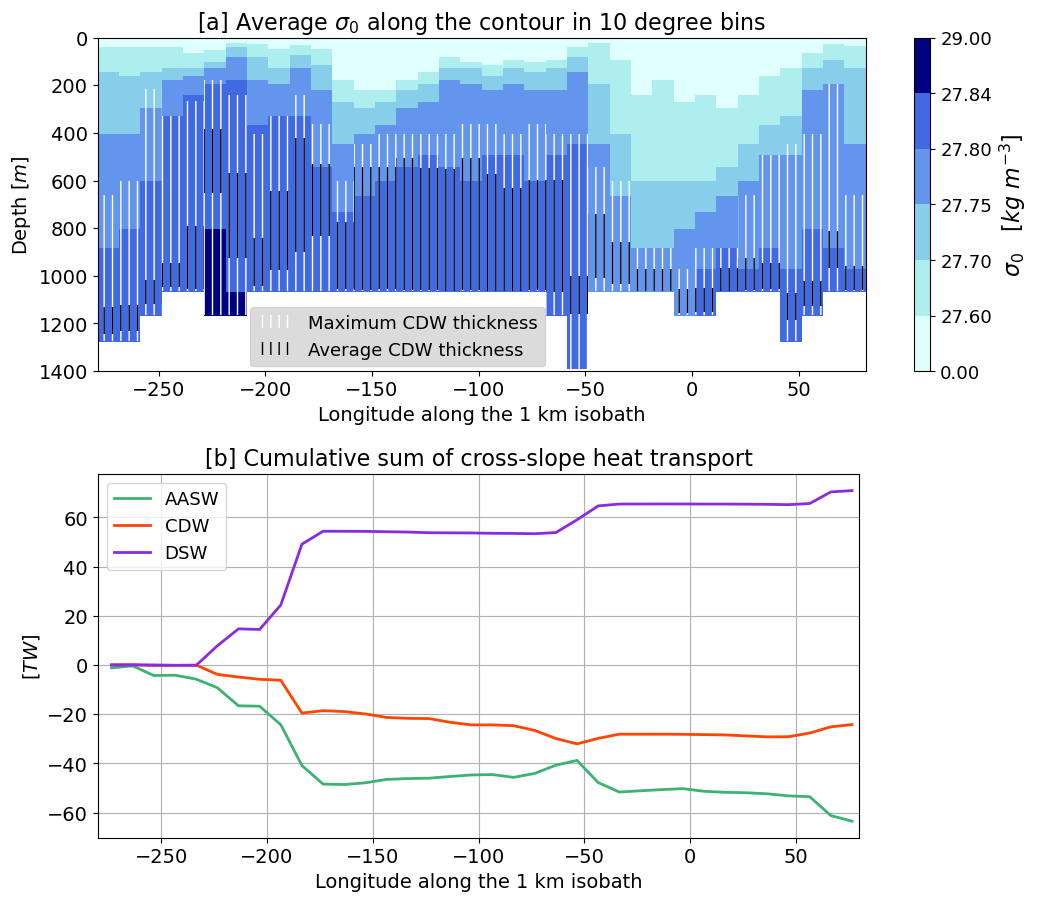

In [672]:
figure = plt.figure(num = 1, figsize = (12, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)

plt.subplot(2,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

plt.fill_between(lon_bin_halo,CDW_light_zmin_halo,CDW_dense_zmax_halo\
                 ,step='mid',hatch="||",color='white',facecolor='none',linewidth=0,label='Maximum CDW thickness')


plt.fill_between(lon_bin_halo,CDW_light_zmean_halo,CDW_dense_zmean_halo,\
                 step='mid',hatch="||",facecolor='none',linewidth=0,label='Average CDW thickness')


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel(r'Depth [$m$]',fontsize=14)
plt.xlabel('Longitude along the 1 km isobath',fontsize=14)

plt.title(r'[a] Average $\sigma_0$ along the contour in 10 degree bins',fontsize=16)
cbr = plt.colorbar(pc)
cbr.ax.set_ylabel(ylabel=r"$\sigma_0$   [$kg\ m^{-3}$]",size=16)
cbr.ax.tick_params(labelsize=13)
legend0 = plt.legend(fontsize=13, bbox_to_anchor=(0.594,0.22))
legend0.get_frame().set_facecolor('lightgrey')


spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[12,0.1], wspace=0.5,
                         hspace=0.2, height_ratios=[1, 1])

ax2 = figure.add_subplot(spec[2])


(AASW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='mediumseagreen',\
                                                                linewidth=2,label='AASW')
(CDW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='orangered',\
                                                                linewidth=2,label='CDW')
(DSW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='blueviolet',\
                                                                linewidth=2,label='DSW')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(-280,80)
plt.title('[b] Cumulative sum of cross-slope heat transport',fontsize=16)
plt.ylabel(r'[$TW$]',fontsize=14)
plt.xlabel('Longitude along the 1 km isobath',fontsize=14)
plt.grid()
legend1 = plt.legend(fontsize=13)

plt.savefig(figdir +'V2_Fig2_CSHTonly',dpi=300)

Version 2, with CSHT + ASC, only for CDW and ASC

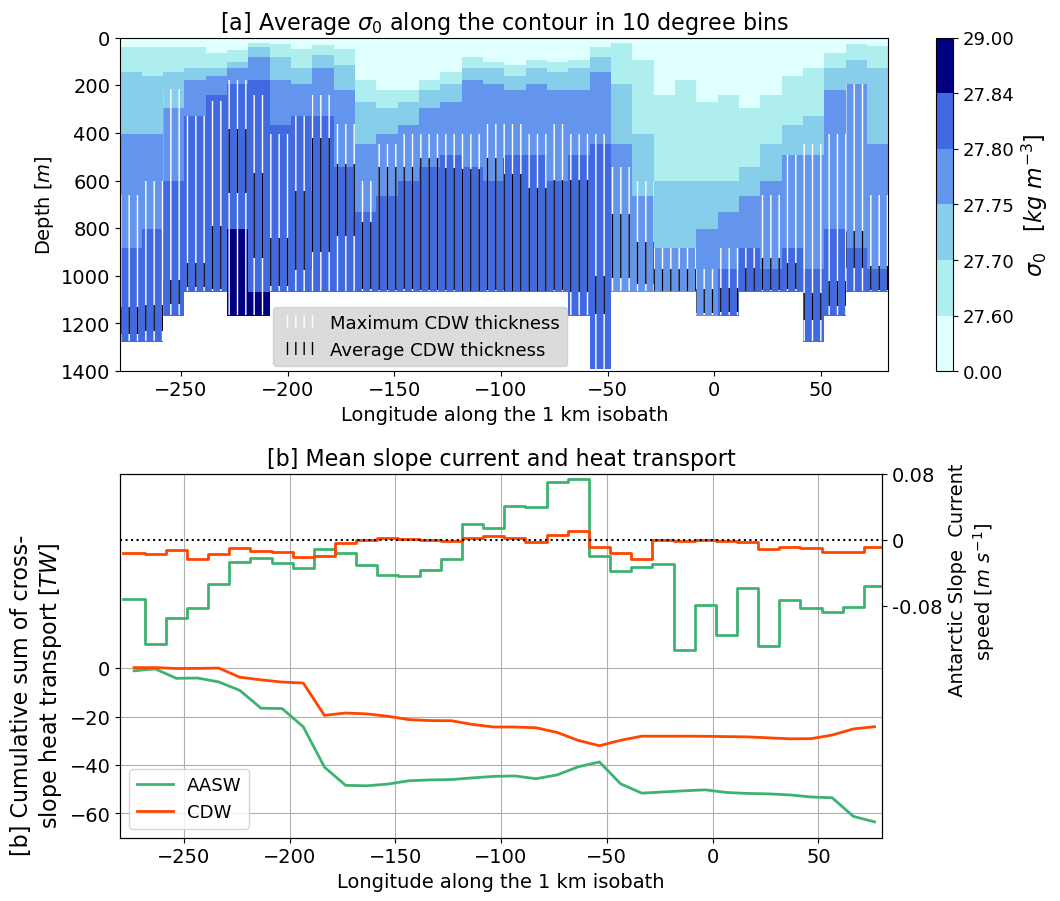

In [673]:
figure = plt.figure(num = 1, figsize = (12, 10))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0,
                    hspace=0.4)

plt.subplot(2,1,1)
norm = col.Normalize(vmin=27.6,vmax=29)
levels = [0,27.6,27.7,27.75,27.8,27.84,29]

pc = σ_10deg_binned.mean('time').plot.pcolormesh(y='st_ocean',levels=levels,\
                                       colors=['lightcyan','paleturquoise','skyblue','cornflowerblue','royalblue',\
                                               'navy'],add_colorbar=False)

plt.fill_between(lon_bin_halo,CDW_light_zmin_halo,CDW_dense_zmax_halo\
                 ,step='mid',hatch="||",color='white',facecolor='none',linewidth=0,label='Maximum CDW thickness')


plt.fill_between(lon_bin_halo,CDW_light_zmean_halo,CDW_dense_zmean_halo,\
                 step='mid',hatch="||",facecolor='none',linewidth=0,label='Average CDW thickness')


plt.ylim(1400,0);
plt.tick_params(labelsize=14)
plt.ylabel(r'Depth [$m$]',fontsize=14)
plt.xlabel('Longitude along the 1 km isobath',fontsize=14)

plt.title(r'[a] Average $\sigma_0$ along the contour in 10 degree bins',fontsize=16)
cbr = plt.colorbar(pc)
cbr.ax.set_ylabel(ylabel=r"$\sigma_0$   [$kg\ m^{-3}$]",size=16)
cbr.ax.tick_params(labelsize=13)
legend0 = plt.legend(fontsize=13, bbox_to_anchor=(0.594,0.22))
legend0.get_frame().set_facecolor('lightgrey')


spec = gridspec.GridSpec(ncols=2, nrows=2,
                         width_ratios=[12,0.1], wspace=0.5,
                         hspace=0.2, height_ratios=[1, 1])

ax2 = figure.add_subplot(spec[2])


(AASW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='mediumseagreen',\
                                                                linewidth=2,label=r'AASW')
(CDW_HT_10deg.mean('time').sum('potrho0')*1e-12).cumsum().plot(ax=ax2,color='orangered',\
                                                                linewidth=2,label=r'CDW')

plt.xticks(fontsize=14)
plt.yticks(ticks=[-60,-40,-20,0],fontsize=14)
plt.xlim(-280,80)
plt.ylabel('[b] Cumulative sum of cross-           \n slope heat transport' +\
           r' [$TW$]          ',fontsize=16)
plt.title(r'                      ',fontsize=14)
plt.xlabel('Longitude along the 1 km isobath',fontsize=14)
plt.grid()
legend1 = plt.legend(fontsize=13,loc=3)
ax2.set_ylim(-70,80)

ax2.set_title('[b] Mean slope current and heat transport',fontsize=16)

ax2right = ax2.twinx()
AASW_U_10deg.plot.step(ax=ax2right,color='mediumseagreen',linewidth=2)
CDW_U_10deg.plot.step(ax=ax2right,color='orangered',linewidth=2)
plt.plot([-280,80],[0,0],linestyle=':',color='black')

ax2right.set_ylim(-.36,.08)
ax2right.set_yticks(ticks=[-.08,0,.08])
ax2right.set_yticklabels(labels=[-.08,0,.08],fontsize=14)
ax2right.set_ylabel('                          Antarctic Slope  Current \n                     speed ' +\
                    r'[$m \ s^{-1}$]',fontsize=14)
plt.savefig(figdir +'V2_Fig2_CSHTandASC',dpi=300)

